Questa cella importa i file JSON dalla directory corrente nella collezione `products` del database `roller_Deca`. La collezione deve essere svuotata (cella di codice commentata) se l'importazione avviene più di una volta, per evitare duplicati.

**Nota**: Assicurati che MongoDB sia in esecuzione con:
```bash
mongod --dbpath /Users/roberto/mongodb-data/db-new --fork --logpath /Users/roberto/mongodb-data/logs/mongod.log

# Packages

In [2]:
%pip install pymongo


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install matplotlib
%pip install seaborn
%pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Libraries

In [3]:
# Libraries
import os
import json
import pandas as pd
from pymongo import MongoClient
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Importazione dei dati JSON in MongoDB

In [4]:
# Connessione al server MongoDB
client = MongoClient('mongodb://localhost:27017/')

In [5]:
# Seleziona il database e la collezione
db = client['roller_RSUK']
collection = db['products']

In [6]:
# Svuota la collezione per evitare duplicati
collection.delete_many({})

DeleteResult({'n': 1453, 'ok': 1.0}, acknowledged=True)

In [7]:
# Percorso della cartella principale
base_directory = '/Users/roberto/Desktop/lavoro_stage_uni/rollersnakes_products/2025'

for month in os.listdir(base_directory):
    month_path = os.path.join(base_directory, month)
    if os.path.isdir(month_path):
        # Itera sui file JSON nella sottocartella
        for filename in os.listdir(month_path):
            if filename.endswith('.json'):
                filepath = os.path.join(month_path, filename)
                try:
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        # Conta i documenti
                        num_docs = len(data) if isinstance(data, list) else 1
                        # Inserisci i dati
                        if isinstance(data, list):
                            collection.insert_many(data)
                        else:
                            collection.insert_one(data)
                        print(f"Importato: {filepath} ({num_docs} documenti)")
                except Exception as e:
                    print(f"Errore nell'importazione di {filepath}: {e}")

print("Importazione completata")
print(f"Totale documenti nella collezione: {collection.count_documents({})}")

Importato: /Users/roberto/Desktop/lavoro_stage_uni/rollersnakes_products/2025/04/products_2025-04-24.json (333 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/rollersnakes_products/2025/05/products_2025-05-02.json (320 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/rollersnakes_products/2025/05/products_2025-05-09.json (318 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/rollersnakes_products/2025/08/products_2025-08-17.json (240 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/rollersnakes_products/2025/08/products_2025-08-16.json (242 documenti)
Importazione completata
Totale documenti nella collezione: 1453


# KPI

### Query per prezzo medio per mese e categoria

In [10]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {"$sort": {"_id.mese": 1, "prezzo_medio": -1}}  # Prima mese (asc), poi prezzo_medio (desc)
]
risultati_KPI1 = list(collection.aggregate(pipeline))

# Stampa risultati
mesi_map = {4: 'Aprile', 5: 'Maggio', 8: 'Agosto'}
for r in risultati_KPI1:
    mese = mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}")
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Prezzo medio: {r['prezzo_medio']:.2f} €")

Mese: Aprile, Categoria: Skates, Prezzo medio: 107.64 €
Mese: Aprile, Categoria: Unknown, Prezzo medio: 80.45 €
Mese: Aprile, Categoria: Accessories, Prezzo medio: 68.70 €
Mese: Aprile, Categoria: Safety Gear, Prezzo medio: 51.09 €
Mese: Aprile, Categoria: Skateboard, Prezzo medio: 11.95 €
Mese: Aprile, Categoria: Footwear, Prezzo medio: 7.05 €
Mese: Maggio, Categoria: Skates, Prezzo medio: 107.42 €
Mese: Maggio, Categoria: Unknown, Prezzo medio: 80.45 €
Mese: Maggio, Categoria: Accessories, Prezzo medio: 68.70 €
Mese: Maggio, Categoria: Safety Gear, Prezzo medio: 52.62 €
Mese: Maggio, Categoria: Skateboard, Prezzo medio: 11.95 €
Mese: Maggio, Categoria: Footwear, Prezzo medio: 7.16 €
Mese: Agosto, Categoria: Accessories, Prezzo medio: 80.66 €
Mese: Agosto, Categoria: Unknown, Prezzo medio: 77.45 €
Mese: Agosto, Categoria: Skates, Prezzo medio: 56.68 €
Mese: Agosto, Categoria: Safety Gear, Prezzo medio: 53.95 €
Mese: Agosto, Categoria: Skateboard, Prezzo medio: 11.95 €
Mese: Agosto, Ca

In [12]:
KPI1_dati = [
    {
        "Mese": mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}"),
        "Categoria": r['_id']['categoria'],
        "Prezzo medio (€)": round(r['prezzo_medio'], 2)
    }
    for r in risultati_KPI1
]

# DataFrame and table
avg_month_price_df = pd.DataFrame(KPI1_dati)
display(avg_month_price_df)

,Mese,Categoria,Prezzo medio (€)
0,Aprile,Skates,107.64
1,Aprile,Unknown,80.45
2,Aprile,Accessories,68.70
3,Aprile,Safety Gear,51.09
4,Aprile,Skateboard,11.95
5,Aprile,Footwear,7.05
6,Maggio,Skates,107.42
7,Maggio,Unknown,80.45
8,Maggio,Accessories,68.70
9,Maggio,Safety Gear,52.62


In [13]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category",
                "sotto-categoria": "$subcategory"
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {"$sort": {"_id.mese": 1, "prezzo_medio": -1}}  # Prima mese (asc), poi prezzo_medio (desc)
]
risultati_KPI1_1 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI1_1:
    mese = mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}")
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Sotto-categoria: {r['_id']['sotto-categoria']}, Prezzo medio: {r['prezzo_medio']:.2f} €")

Mese: Aprile, Categoria: Skates, Sotto-categoria: Aggressive, Prezzo medio: 254.86 €
Mese: Aprile, Categoria: Skates, Sotto-categoria: Inline, Prezzo medio: 131.46 €
Mese: Aprile, Categoria: Skates, Sotto-categoria: Quad, Prezzo medio: 113.11 €
Mese: Aprile, Categoria: Accessories, Sotto-categoria: Backpacks, Prezzo medio: 85.28 €
Mese: Aprile, Categoria: Unknown, Sotto-categoria: Unknown, Prezzo medio: 80.45 €
Mese: Aprile, Categoria: Safety Gear, Sotto-categoria: Pad Sets, Prezzo medio: 51.09 €
Mese: Aprile, Categoria: Skates, Sotto-categoria: Inline Hardware, Prezzo medio: 48.26 €
Mese: Aprile, Categoria: Skates, Sotto-categoria: Quad Wheels, Prezzo medio: 37.28 €
Mese: Aprile, Categoria: Skates, Sotto-categoria: Quad Accessories, Prezzo medio: 36.18 €
Mese: Aprile, Categoria: Accessories, Sotto-categoria: Socks, Prezzo medio: 18.95 €
Mese: Aprile, Categoria: Skateboard, Sotto-categoria: Wheels, Prezzo medio: 11.95 €
Mese: Aprile, Categoria: Skates, Sotto-categoria: Quad Stoppers, P

In [14]:
KPI1_1_dati = [
    {
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Sotto-categoria": r['_id']['sotto-categoria'],
        "Prezzo medio (€)": round(r['prezzo_medio'], 2)
    }
    for r in risultati_KPI1_1
    if r['_id']['mese'] == 4
]

# DataFrame and table
avg_month_sub_price_df = pd.DataFrame(KPI1_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_sub_price_df)

,Mese,Categoria,Sotto-categoria,Prezzo medio (€)
0,Aprile,Skates,Aggressive,254.86
1,Aprile,Skates,Inline,131.46
2,Aprile,Skates,Quad,113.11
3,Aprile,Accessories,Backpacks,85.28
4,Aprile,Unknown,Unknown,80.45
5,Aprile,Safety Gear,Pad Sets,51.09
6,Aprile,Skates,Inline Hardware,48.26
7,Aprile,Skates,Quad Wheels,37.28
8,Aprile,Skates,Quad Accessories,36.18
9,Aprile,Accessories,Socks,18.95


In [15]:
KPI1_1_dati = [
    {
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Sotto-categoria": r['_id']['sotto-categoria'],
        "Prezzo medio (€)": round(r['prezzo_medio'], 2)
    }
    for r in risultati_KPI1_1
    if r['_id']['mese'] == 5
]

# DataFrame and table
avg_month_sub_price_df = pd.DataFrame(KPI1_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_sub_price_df)

,Mese,Categoria,Sotto-categoria,Prezzo medio (€)
0,Maggio,Skates,Aggressive,259.83
1,Maggio,Skates,Inline,131.46
2,Maggio,Skates,Quad,111.72
3,Maggio,Accessories,Backpacks,85.28
4,Maggio,Unknown,Unknown,80.45
5,Maggio,Safety Gear,Pad Sets,52.62
6,Maggio,Skates,Inline Hardware,48.55
7,Maggio,Skates,Quad Accessories,38.16
8,Maggio,Skates,Quad Wheels,35.15
9,Maggio,Accessories,Socks,18.95


In [16]:
KPI1_1_dati = [
    {
        "Mese": "Agosto",
        "Categoria": r['_id']['categoria'],
        "Sotto-categoria": r['_id']['sotto-categoria'],
        "Prezzo medio (€)": round(r['prezzo_medio'], 2)
    }
    for r in risultati_KPI1_1
    if r['_id']['mese'] == 8
]

# DataFrame and table
avg_month_sub_price_df = pd.DataFrame(KPI1_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_sub_price_df)

,Mese,Categoria,Sotto-categoria,Prezzo medio (€)
0,Agosto,Skates,Aggressive,114.20
1,Agosto,Skates,Inline,91.67
2,Agosto,Skates,Quad,85.56
3,Agosto,Accessories,Backpacks,80.66
4,Agosto,Unknown,Unknown,77.45
5,Agosto,Safety Gear,Pad Sets,53.95
6,Agosto,Skates,Inline Hardware,48.28
7,Agosto,Skates,Quad Wheels,28.31
8,Agosto,Skates,Quad Accessories,27.91
9,Agosto,Skates,Quad Stoppers,13.34


### KPI: Top 5 prodotti per numero di recensioni

In [19]:
pipeline = [
    {"$group": {"_id": {"brand": "$brand"}, "recensioni_totali": {"$sum": "$num_reviews"}}},
    {"$sort": {"recensioni_totali": -1}},
    {"$limit": 5}
]
risultati_KPI2 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI2:
    print(f"Prodotto: {r['_id']['brand']}, Recensioni: {r['recensioni_totali']}")

Prodotto: Rio Roller, Recensioni: 91
Prodotto: Supreme, Recensioni: 90
Prodotto: Mindless, Recensioni: 72
Prodotto: Impala, Recensioni: 48
Prodotto: SFR, Recensioni: 25


### KPI: Sconto medio settimanale (per RSUK non abbiamo informazioni di sconto)

In [ ]:
pipeline = [
    {
        "$group": {
            "_id": {
                "$dateToString": {
                    "format": "%Y-%m-%d",
                    "date": {"$toDate": "$scraped_at"}
                }
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id": 1}}
]
risultati_KPI3 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI3:
    print(f"Data: {r['_id']}, Sconto medio: {r['sconto_medio']:.2f}%")

In [ ]:
KPI3_dati = [
    {
        "Data": r['_id'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI3
]

# DataFrame e tabella
avg_week_discount_df = pd.DataFrame(KPI3_dati)
display(avg_week_discount_df)

### KPI: sconto medio per settimana e categoria

In [ ]:
pipeline = [
    {
        "$group": {
            "_id": {
                "data": {
                    "$dateToString": {
                        "format": "%Y-%m-%d",
                        "date": {"$toDate": "$scraped_at"}
                    }
                },
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id.data": 1, "_id.mese": 1, "_id.categoria": 1}}
]
risultati_KPI3_1 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI3_1:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Data: {r['_id']['data']}, Mese: {mese}, Categoria: {r['_id']['categoria']}, Sconto medio: {r['sconto_medio']:.2f}%")

In [ ]:
KPI3_1_dati = [
    {
        "Data": r['_id']['data'],
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI3_1
    if r['_id']['mese'] == 4
]

# DataFrame and table
avg_week_cat_sale_df4 = pd.DataFrame(KPI3_1_dati)
pd.set_option('display.max_rows', None)
display(avg_week_cat_sale_df4)

In [ ]:
KPI3_1_dati = [
    {
        "Data": r['_id']['data'],
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI3_1
    if r['_id']['mese'] == 5
]

# DataFrame and table
avg_week_cat_sale_df5 = pd.DataFrame(KPI3_1_dati)
pd.set_option('display.max_rows', None)
display(avg_week_cat_sale_df5)

### KPI: Sconto Medio per Mese e Categoria

In [ ]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id.mese": 1, "prezzo_medio": -1}}  # Prima mese (asc), poi prezzo_medio (desc)
]
risultati_KPI4 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI4:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Sconto medio: {r['sconto_medio']:.2f} %")

In [ ]:
KPI4_1_dati = [
    {
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI4
    if r['_id']['mese'] == 4
]

# DataFrame and table
avg_month_cat_sale_df = pd.DataFrame(KPI4_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_cat_sale_df.sort_values(by='Sconto medio (%)', ascending=False))

In [ ]:
KPI4_1_dati = [
    {
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI4
    if r['_id']['mese'] == 5
]

# DataFrame and table
avg_month_cat_sale_df = pd.DataFrame(KPI4_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_cat_sale_df.sort_values(by='Sconto medio (%)', ascending=False))

### KPI: Punteggio Medio per Categorie e Mese

In [21]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "punteggio_medio": {"$avg": "$score/5"}
        }
    },
    {"$sort": {"_id.mese": 1, "punteggio_medio": -1}}  
]
risultati_KPI5 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI5:
    mese = mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}")
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Punteggio medio: {r['punteggio_medio']:.2f}/5")

Mese: Aprile, Categoria: Skateboard, Punteggio medio: 4.85/5
Mese: Aprile, Categoria: Skates, Punteggio medio: 0.84/5
Mese: Aprile, Categoria: Safety Gear, Punteggio medio: 0.71/5
Mese: Aprile, Categoria: Footwear, Punteggio medio: 0.00/5
Mese: Aprile, Categoria: Unknown, Punteggio medio: 0.00/5
Mese: Aprile, Categoria: Accessories, Punteggio medio: 0.00/5
Mese: Maggio, Categoria: Skateboard, Punteggio medio: 4.86/5
Mese: Maggio, Categoria: Skates, Punteggio medio: 0.85/5
Mese: Maggio, Categoria: Footwear, Punteggio medio: 0.00/5
Mese: Maggio, Categoria: Safety Gear, Punteggio medio: 0.00/5
Mese: Maggio, Categoria: Unknown, Punteggio medio: 0.00/5
Mese: Maggio, Categoria: Accessories, Punteggio medio: 0.00/5
Mese: Agosto, Categoria: Skateboard, Punteggio medio: 4.88/5
Mese: Agosto, Categoria: Skates, Punteggio medio: 0.70/5
Mese: Agosto, Categoria: Accessories, Punteggio medio: 0.00/5
Mese: Agosto, Categoria: Footwear, Punteggio medio: 0.00/5
Mese: Agosto, Categoria: Unknown, Punteggio

In [22]:
KPI5_dati = [
    {
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2)
    }
    for r in risultati_KPI5
    if r['_id']['mese'] == 4
]

# DataFrame e tabella
score_medio_df = pd.DataFrame(KPI5_dati)
display(score_medio_df)

,Mese,Categoria,Punteggio medio (/5)
0,Aprile,Skateboard,4.85
1,Aprile,Skates,0.84
2,Aprile,Safety Gear,0.71
3,Aprile,Footwear,0.00
4,Aprile,Unknown,0.00
5,Aprile,Accessories,0.00


In [23]:
KPI5_dati = [
    {
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2)
    }
    for r in risultati_KPI5
    if r['_id']['mese'] == 5
]

# DataFrame e tabella
score_medio_df = pd.DataFrame(KPI5_dati)
display(score_medio_df)

,Mese,Categoria,Punteggio medio (/5)
0,Maggio,Skateboard,4.86
1,Maggio,Skates,0.85
2,Maggio,Footwear,0.00
3,Maggio,Safety Gear,0.00
4,Maggio,Unknown,0.00
5,Maggio,Accessories,0.00


In [24]:
KPI5_dati = [
    {
        "Mese": "Agosto",
        "Categoria": r['_id']['categoria'],
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2)
    }
    for r in risultati_KPI5
    if r['_id']['mese'] == 8
]

# DataFrame e tabella
score_medio_df = pd.DataFrame(KPI5_dati)
display(score_medio_df)

,Mese,Categoria,Punteggio medio (/5)
0,Agosto,Skateboard,4.88
1,Agosto,Skates,0.70
2,Agosto,Accessories,0.00
3,Agosto,Footwear,0.00
4,Agosto,Unknown,0.00
5,Agosto,Safety Gear,0.00


### KPI: Top 10 Prodotti per Punteggio Medio

In [25]:
pipeline = [
    {
        "$group": {
            "_id": {
                "brand": "$brand",
                "categoria": "$category"
            },
            "punteggio_medio": {"$avg": "$score/5"},
            "recensioni_totali": {"$sum": "$num_reviews"}  
        }
    },
    {"$sort": {"punteggio_medio": -1, "recensioni_totali": -1}},  # Ordina per punteggio, poi recensioni
    {"$limit": 10}
]
risultati_KPI6 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI6:
    print(f"Prodotto: {r['_id']['brand']}, Categoria: {r['_id']['categoria']}, "
          f"Punteggio medio: {r['punteggio_medio']:.2f}/5, Recensioni: {r['recensioni_totali']}")

Prodotto: Mindless, Categoria: Skateboard, Punteggio medio: 4.86/5, Recensioni: 72
Prodotto: Supreme, Categoria: Skates, Punteggio medio: 2.27/5, Recensioni: 90
Prodotto: Sims, Categoria: Skates, Punteggio medio: 1.50/5, Recensioni: 6
Prodotto: Gawds, Categoria: Skates, Punteggio medio: 1.50/5, Recensioni: 6
Prodotto: Razors, Categoria: Skates, Punteggio medio: 1.49/5, Recensioni: 17
Prodotto: Playlife, Categoria: Skates, Punteggio medio: 1.43/5, Recensioni: 4
Prodotto: Rio Roller, Categoria: Skates, Punteggio medio: 1.24/5, Recensioni: 91
Prodotto: Moxi, Categoria: Skates, Punteggio medio: 1.05/5, Recensioni: 5
Prodotto: USD, Categoria: Skates, Punteggio medio: 0.85/5, Recensioni: 19
Prodotto: Impala, Categoria: Skates, Punteggio medio: 0.83/5, Recensioni: 47


### KPI: Punteggio medio per brand (ordinati per numero recensioni)

In [26]:
pipeline = [
    {
        "$group": {
            "_id": "$brand",
            "punteggio_medio": {"$avg": "$score/5"},
            "recensioni_totali": {"$sum": "$num_reviews"}
        }
    },
    {"$sort": {"recensioni_totali": -1}}  # Ordina per numero recensioni (desc)
]
risultati_KPI7 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI7:
    punteggio = f"{r['punteggio_medio']:.2f}" if r['punteggio_medio'] is not None else "N/A"
    print(f"Brand: {r['_id']}, Punteggio medio: {punteggio}/5, Recensioni: {r['recensioni_totali']}")

Brand: Rio Roller, Punteggio medio: 1.24/5, Recensioni: 91
Brand: Supreme, Punteggio medio: 2.14/5, Recensioni: 90
Brand: Mindless, Punteggio medio: 4.86/5, Recensioni: 72
Brand: Impala, Punteggio medio: 0.75/5, Recensioni: 48
Brand: SFR, Punteggio medio: 0.75/5, Recensioni: 25
Brand: USD, Punteggio medio: 0.85/5, Recensioni: 19
Brand: Razors, Punteggio medio: 1.22/5, Recensioni: 17
Brand: Unknown, Punteggio medio: 0.60/5, Recensioni: 16
Brand: Chaya, Punteggio medio: 0.29/5, Recensioni: 14
Brand: Anarchy, Punteggio medio: 0.80/5, Recensioni: 9
Brand: Rookie, Punteggio medio: 0.64/5, Recensioni: 8
Brand: Sims, Punteggio medio: 1.50/5, Recensioni: 6
Brand: Gawds, Punteggio medio: 1.50/5, Recensioni: 6
Brand: Moxi, Punteggio medio: 1.05/5, Recensioni: 5
Brand: Playlife, Punteggio medio: 1.43/5, Recensioni: 4
Brand: Powerslide, Punteggio medio: 0.00/5, Recensioni: 0
Brand: Rollerbones, Punteggio medio: 0.00/5, Recensioni: 0
Brand: Rollerblade, Punteggio medio: 0.00/5, Recensioni: 0
Brand:

In [27]:
KPI7_dati = [
    {
        "Brand": r['_id'],
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2) if r['punteggio_medio'] is not None else "N/A",
        "Recensioni totali": r['recensioni_totali']
    }
    for r in risultati_KPI7
]

# DataFrame e tabella
brand_score_df = pd.DataFrame(risultati_KPI7)
pd.set_option('display.max_rows', None)
display(brand_score_df)

,_id,punteggio_medio,recensioni_totali
0,Rio Roller,1.237745,91
1,Supreme,2.137108,90
2,Mindless,4.864000,72
3,Impala,0.754545,48
4,SFR,0.748503,25
5,USD,0.854839,19
6,Razors,1.218182,17
7,Unknown,0.596330,16
8,Chaya,0.287356,14
9,Anarchy,0.800000,9


#### Top 10 Brand per Numero Recensioni

In [28]:
display(brand_score_df[:10])

,_id,punteggio_medio,recensioni_totali
0,Rio Roller,1.237745,91
1,Supreme,2.137108,90
2,Mindless,4.864000,72
3,Impala,0.754545,48
4,SFR,0.748503,25
5,USD,0.854839,19
6,Razors,1.218182,17
7,Unknown,0.596330,16
8,Chaya,0.287356,14
9,Anarchy,0.800000,9


#### Top 10 Brand per Score Medio

In [59]:
display(brand_score_df.sort_values(by='punteggio_medio', ascending=False)[:10])

,_id,punteggio_medio,recensioni_totali
2,Mindless,4.864000,72
1,Supreme,2.137108,90
11,Sims,1.500000,6
12,Gawds,1.500000,6
14,Playlife,1.428571,4
0,Rio Roller,1.237745,91
6,Razors,1.218182,17
13,Moxi,1.052632,5
5,USD,0.854839,19
9,Anarchy,0.800000,9


### KPI: Variazione di prezzo per prodotto

In [29]:
# Query per variazione di prezzo
pipeline = [
    {
        "$group": {
            "_id": {
                "brand": "$brand",
                "settimana": {
                    "$dateToString": {"format": "%Y-%m-%d", "date": {"$toDate": "$scraped_at"}}
                }
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {
        "$sort": {"_id.brand": 1, "_id.settimana": 1}
    },
    {
        "$group": {
            "_id": {"brand": "$_id.brand", "nome": "$_id.nome"},
            "prezzi": {
                "$push": {
                    "settimana": "$_id.settimana",
                    "prezzo": "$prezzo_medio"
                }
            }
        }
    },
    {
        "$project": {
            "variazione_max": {
                "$subtract": [
                    {"$max": "$prezzi.prezzo"},
                    {"$min": "$prezzi.prezzo"}
                ]
            }
        }
    },
    {"$sort": {"variazione_max": -1}},
    {"$limit": 5}
]
risultati_KPI8 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI8:
    print(f"Prodotto: {r['_id']['brand']}, Variazione prezzo: {r['variazione_max']:.2f} €")

Prodotto: USD, Variazione prezzo: 235.06 €
Prodotto: Razors, Variazione prezzo: 157.33 €
Prodotto: Roces, Variazione prezzo: 107.00 €
Prodotto: Sims, Variazione prezzo: 88.50 €
Prodotto: Unknown, Variazione prezzo: 81.30 €


In [30]:
KPI8_dati = [
    {
        "Prodotto": f"{r['_id']['brand']}",
        "Variazione prezzo (€)": round(r['variazione_max'], 2)
    }
    for r in risultati_KPI8
]

# DataFrame e tabella
variazione_prezzo_df = pd.DataFrame(KPI8_dati)
display(variazione_prezzo_df)

,Prodotto,Variazione prezzo (€)
0,USD,235.06
1,Razors,157.33
2,Roces,107.00
3,Sims,88.50
4,Unknown,81.30


### KPI: % di prodotti in sconto per categoria

In [ ]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "totale_prodotti": {"$sum": 1},
            "prodotti_in_sconto": {
                "$sum": {
                    "$cond": [
                        {
                            "$gt": [
                                {
                                    "$toDouble": {
                                        "$cond": [
                                            {"$eq": ["$sale%", "Not on sale"]},
                                            0,
                                            "$sale%"
                                        ]
                                    }
                                },
                                0
                            ]
                        },
                        1,
                        0
                    ]
                }
            }
        }
    },
    {
        "$project": {
            "totale_prodotti": 1,
            "prodotti_in_sconto": 1,
            "percentuale_sconto": {
                "$multiply": [
                    {"$divide": ["$prodotti_in_sconto", "$totale_prodotti"]},
                    100
                ]
            }
        }
    },
    {"$sort": {"_id.mese": 1, "percentuale_sconto": -1}}
]
risultati_KPI9 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI9:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(
        f"Mese: {mese}, Categoria: {r['_id']['categoria']}, "
        f"Prodotti in sconto: {r.get('prodotti_in_sconto', 0)}, "
        f"Totale prodotti: {r.get('totale_prodotti', 0)}, "
        f"Percentuale in sconto: {r.get('percentuale_sconto', 0):.2f}%"
    )

In [ ]:
KPI9_dati = [
    {
        "Mese": ['Aprile', 'Maggio'][r['_id']['mese'] - 4],
        "Categoria": r['_id']['categoria'],
        "Prodotti in sconto": r['prodotti_in_sconto'],
        "Totale prodotti": r['totale_prodotti'],
        "Percentuale in sconto (%)": round(r['percentuale_sconto'], 2)
    }
    for r in risultati_KPI9
    if r['_id']['mese'] == 4
]

# DataFrame e tabella
prodotti_sconto_df = pd.DataFrame(KPI9_dati)
display(prodotti_sconto_df)

In [ ]:
KPI9_dati = [
    {
        "Mese": ['Aprile', 'Maggio'][r['_id']['mese'] - 4],
        "Categoria": r['_id']['categoria'],
        "Prodotti in sconto": r['prodotti_in_sconto'],
        "Totale prodotti": r['totale_prodotti'],
        "Percentuale in sconto (%)": round(r['percentuale_sconto'], 2)
    }
    for r in risultati_KPI9
    if r['_id']['mese'] == 5
]

# DataFrame e tabella
prodotti_sconto_df = pd.DataFrame(KPI9_dati)
display(prodotti_sconto_df)

### KPI: Prodotti più stabili nel punteggio (con almeno 500 recensioni)

In [32]:
pipeline = [
    {
        "$match": {"score/5": {"$exists": True, "$ne": None, "$type": ["double", "int", "decimal"]}}
    },
    {
        "$group": {
            "_id": {"brand": "$brand"},
            "deviazione_std": {"$stdDevSamp": "$score/5"},
            "punteggio_medio": {"$avg": "$score/5"},
            "num_recensioni": {"$sum": "$num_reviews"}
        }
    },
    {
        "$match": {"num_recensioni": {"$gte": 20}}
    },
    {"$sort": {"deviazione_std": 1}},
    {"$limit": 5}
]
risultati_KPI10 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI10:
    dev_std = f"{r['deviazione_std']:.2f}" if r['deviazione_std'] is not None else "N/A"
    punteggio = f"{r['punteggio_medio']:.2f}" if r['punteggio_medio'] is not None else "N/A"
    print(f"Prodotto: {r['_id']['brand']}, "
          f"Deviazione standard: {dev_std}, "
          f"Punteggio medio: {punteggio}/5, "
          f"Recensioni: {r['num_recensioni']}")

Prodotto: Mindless, Deviazione standard: 0.02, Punteggio medio: 4.86/5, Recensioni: 72
Prodotto: Impala, Deviazione standard: 1.76, Punteggio medio: 0.75/5, Recensioni: 48
Prodotto: SFR, Deviazione standard: 1.79, Punteggio medio: 0.75/5, Recensioni: 25
Prodotto: Rio Roller, Deviazione standard: 2.15, Punteggio medio: 1.24/5, Recensioni: 91
Prodotto: Supreme, Deviazione standard: 2.42, Punteggio medio: 2.14/5, Recensioni: 90


In [33]:
KPI10_dati = [
    {
        "Prodotto": f"{r['_id']['brand']}",
        "Deviazione standard": round(r['deviazione_std'], 2) if r['deviazione_std'] is not None else "N/A",
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2) if r['punteggio_medio'] is not None else "N/A",
        "Recensioni": r['num_recensioni']
    }
    for r in risultati_KPI10
]

# DataFrame e tabella
prodotti_stabili_df = pd.DataFrame(KPI10_dati)
display(prodotti_stabili_df.sort_values(by='Recensioni', ascending=False))

,Prodotto,Deviazione standard,Punteggio medio (/5),Recensioni
3,Rio Roller,2.15,1.24,91
4,Supreme,2.42,2.14,90
0,Mindless,0.02,4.86,72
1,Impala,1.76,0.75,48
2,SFR,1.79,0.75,25


### KPI:  Disponibilità dei prodotti per brand

In [37]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "brand": "$brand"
            },
            "totale_prodotti": {"$sum": 1},
            "disponibili": {
                "$sum": {"$cond": [{"$eq": ["$availability", "In stock"]}, 1, 0]}
            }
        }
    },
    {
        "$project": {
            "totale_prodotti": 1,
            "disponibili": 1,
            "percentuale_disponibili": {
                "$multiply": [
                    {"$divide": ["$disponibili", "$totale_prodotti"]},
                    100
                ]
            }
        }
    },
    {"$sort": {"_id.mese": 1, "percentuale_disponibili": -1}}
]
risultati_KPI11 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI11:
    mese = mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}")
    print(f"Mese: {mese}, Brand: {r['_id']['brand']}, "
          f"Totale prodotti: {r.get('totale_prodotti', 0)}, "
          f"Disponibili: {r.get('disponibili', 0)}, "
          f"Percentuale disponibili: {r['percentuale_disponibili']:.2f}%")

Mese: Aprile, Brand: Clouds, Totale prodotti: 5, Disponibili: 5, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: Mindless, Totale prodotti: 1, Disponibili: 1, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: Derby Laces, Totale prodotti: 14, Disponibili: 9, Percentuale disponibili: 64.29%
Mese: Aprile, Brand: Shoestring, Totale prodotti: 8, Disponibili: 5, Percentuale disponibili: 62.50%
Mese: Aprile, Brand: Rookie, Totale prodotti: 9, Disponibili: 5, Percentuale disponibili: 55.56%
Mese: Aprile, Brand: Skatelife, Totale prodotti: 2, Disponibili: 1, Percentuale disponibili: 50.00%
Mese: Aprile, Brand: Sims, Totale prodotti: 6, Disponibili: 3, Percentuale disponibili: 50.00%
Mese: Aprile, Brand: Supreme, Totale prodotti: 17, Disponibili: 6, Percentuale disponibili: 35.29%
Mese: Aprile, Brand: Playmaker, Totale prodotti: 3, Disponibili: 1, Percentuale disponibili: 33.33%
Mese: Aprile, Brand: Impala, Totale prodotti: 52, Disponibili: 14, Percentuale disponibili: 26.92%
Mese: Ap

In [42]:
KPI11_dati = [
    {
        "Mese": mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}"),
        "Brand": r['_id']['brand'],
        "Totale prodotti": r.get('totale_prodotti', 0),
        "Disponibili": r.get('disponibili', 0),
        "Percentuale disponibili (%)": round(r['percentuale_disponibili'], 2)
    }
    for r in risultati_KPI11
    if r['_id']['mese'] == 4
]

# DataFrame e tabella
disponibilita_aprile_brand_df = pd.DataFrame(KPI11_dati)
display(disponibilita_aprile_brand_df)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Aprile,Clouds,5,5,100.00
1,Aprile,Mindless,1,1,100.00
2,Aprile,Derby Laces,14,9,64.29
3,Aprile,Shoestring,8,5,62.50
4,Aprile,Rookie,9,5,55.56
5,Aprile,Skatelife,2,1,50.00
6,Aprile,Sims,6,3,50.00
7,Aprile,Supreme,17,6,35.29
8,Aprile,Playmaker,3,1,33.33
9,Aprile,Impala,52,14,26.92


In [43]:
KPI11_dati = [
    {
        "Mese": mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}"),
        "Brand": r['_id']['brand'],
        "Totale prodotti": r.get('totale_prodotti', 0),
        "Disponibili": r.get('disponibili', 0),
        "Percentuale disponibili (%)": round(r['percentuale_disponibili'], 2)
    }
    for r in risultati_KPI11
    if r['_id']['mese'] == 5
]

# DataFrame e tabella
disponibilita_maggio_brand_df = pd.DataFrame(KPI11_dati)
display(disponibilita_maggio_brand_df)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Maggio,Mindless,2,2,100.00
1,Maggio,Clouds,10,9,90.00
2,Maggio,Shoestring,14,10,71.43
3,Maggio,Derby Laces,26,18,69.23
4,Maggio,Rookie,18,10,55.56
5,Maggio,Sims,12,6,50.00
6,Maggio,Skatelife,4,2,50.00
7,Maggio,Supreme,34,12,35.29
8,Maggio,Playmaker,6,2,33.33
9,Maggio,Impala,102,28,27.45


In [47]:
KPI11_dati = [
    {
        "Mese": mesi_map.get(r['_id']['mese'], f"Mese {r['_id']['mese']}"),
        "Brand": r['_id']['brand'],
        "Totale prodotti": r.get('totale_prodotti', 0),
        "Disponibili": r.get('disponibili', 0),
        "Percentuale disponibili (%)": round(r['percentuale_disponibili'], 2)
    }
    for r in risultati_KPI11
    if r['_id']['mese'] == 8
]

# DataFrame e tabella
disponibilita_agosto_brand_df = pd.DataFrame(KPI11_dati)
display(disponibilita_agosto_brand_df)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Agosto,Sims,2,2,100.00
1,Agosto,Mindless,2,2,100.00
2,Agosto,Rookie,12,8,66.67
3,Agosto,USD,6,4,66.67
4,Agosto,Supreme,32,12,37.50
5,Agosto,Impala,66,22,33.33
6,Agosto,SFR,66,22,33.33
7,Agosto,Playmaker,6,2,33.33
8,Agosto,Razors,6,2,33.33
9,Agosto,Shoestring,12,4,33.33


In [48]:
# Brand con disponibilità 100%
df_100_aprile = disponibilita_aprile_brand_df[disponibilita_aprile_brand_df["Percentuale disponibili (%)"] == 100]
display(df_100_aprile)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Aprile,Clouds,5,5,100.0
1,Aprile,Mindless,1,1,100.0


In [49]:
# Brand con disponibilità < 100%
df_meno_100_aprile = disponibilita_aprile_brand_df[disponibilita_aprile_brand_df["Percentuale disponibili (%)"] < 100]
display(df_meno_100_aprile)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
2,Aprile,Derby Laces,14,9,64.29
3,Aprile,Shoestring,8,5,62.50
4,Aprile,Rookie,9,5,55.56
5,Aprile,Skatelife,2,1,50.00
6,Aprile,Sims,6,3,50.00
7,Aprile,Supreme,17,6,35.29
8,Aprile,Playmaker,3,1,33.33
9,Aprile,Impala,52,14,26.92
10,Aprile,Rio Roller,42,9,21.43
11,Aprile,SFR,34,7,20.59


In [50]:
# Brand con disponibilità 100%
df_100_maggio = disponibilita_maggio_brand_df[disponibilita_maggio_brand_df["Percentuale disponibili (%)"] == 100]
display(df_100_maggio)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Maggio,Mindless,2,2,100.0


In [51]:
# Brand con disponibilità < 100%
df_meno_100_maggio = disponibilita_maggio_brand_df[disponibilita_maggio_brand_df["Percentuale disponibili (%)"] < 100]
display(df_meno_100_maggio)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
1,Maggio,Clouds,10,9,90.00
2,Maggio,Shoestring,14,10,71.43
3,Maggio,Derby Laces,26,18,69.23
4,Maggio,Rookie,18,10,55.56
5,Maggio,Sims,12,6,50.00
6,Maggio,Skatelife,4,2,50.00
7,Maggio,Supreme,34,12,35.29
8,Maggio,Playmaker,6,2,33.33
9,Maggio,Impala,102,28,27.45
10,Maggio,SFR,67,17,25.37


In [52]:
# Brand con disponibilità 100%
df_100_agosto = disponibilita_agosto_brand_df[disponibilita_agosto_brand_df["Percentuale disponibili (%)"] == 100]
display(df_100_agosto)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Agosto,Sims,2,2,100.0
1,Agosto,Mindless,2,2,100.0


In [54]:
# Brand con disponibilità <100%
df_meno_100_agosto = disponibilita_agosto_brand_df[disponibilita_agosto_brand_df["Percentuale disponibili (%)"] < 100]
display(df_meno_100_agosto)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
2,Agosto,Rookie,12,8,66.67
3,Agosto,USD,6,4,66.67
4,Agosto,Supreme,32,12,37.50
5,Agosto,Impala,66,22,33.33
6,Agosto,SFR,66,22,33.33
7,Agosto,Playmaker,6,2,33.33
8,Agosto,Razors,6,2,33.33
9,Agosto,Shoestring,12,4,33.33
10,Agosto,Clouds,8,2,25.00
11,Agosto,Rio Roller,80,18,22.50


### KPI: Correlazione tra sconto e numero di recensioni

In [ ]:
pipeline = [
    {
        "$addFields": {
            "sale_num": {
                "$cond": [
                    {"$eq": ["$sale%", "Not on sale"]},
                    0,
                    {"$toDouble": "$sale%"}
                ]
            }
        }
    },
    {
        "$bucket": {
            "groupBy": "$sale_num",
            "boundaries": [0, 10, 20, 30, 40, 50, 60, 70],
            "default": "60+",
            "output": {
                "recensioni_medie": {"$avg": "$num_reviews"},
                "count": {"$sum": 1}
            }
        }
    },
    {"$sort": {"_id": 1}}
]
risultati_KPI12 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI12:
    fascia = r['_id']
    recensioni_medie = round(r['recensioni_medie'], 2) if r['recensioni_medie'] is not None else 0
    count = r['count']
    print(f"Fascia sconto: {fascia}, Recensioni medie: {recensioni_medie}, Numero prodotti: {count}")

In [ ]:
def fascia_to_intervallo(fascia):
    if fascia == 0:
        return "0–9"
    elif fascia == 10:
        return "10–19"
    elif fascia == 20:
        return "20–29"
    elif fascia == 30:
        return "30–39"
    elif fascia == 40:
        return "40–49"
    elif fascia == 50:
        return "50–59"
    elif fascia == 60:
        return "60–69"
    elif fascia == "60+":
        return "70+"
    else:
        return str(fascia)

KPI12_dati = [
    {
        "Intervallo sconto (%)": fascia_to_intervallo(r['_id']),
        "Recensioni medie": round(r['recensioni_medie'], 2) if r['recensioni_medie'] is not None else 0,
        "Numero prodotti": r['count']
    }
    for r in risultati_KPI12
]
kpi12_df = pd.DataFrame(KPI12_dati)
display(kpi12_df)

# Rappresentazioni Grafiche

### Grafico: Prezzo medio per mese e categoria

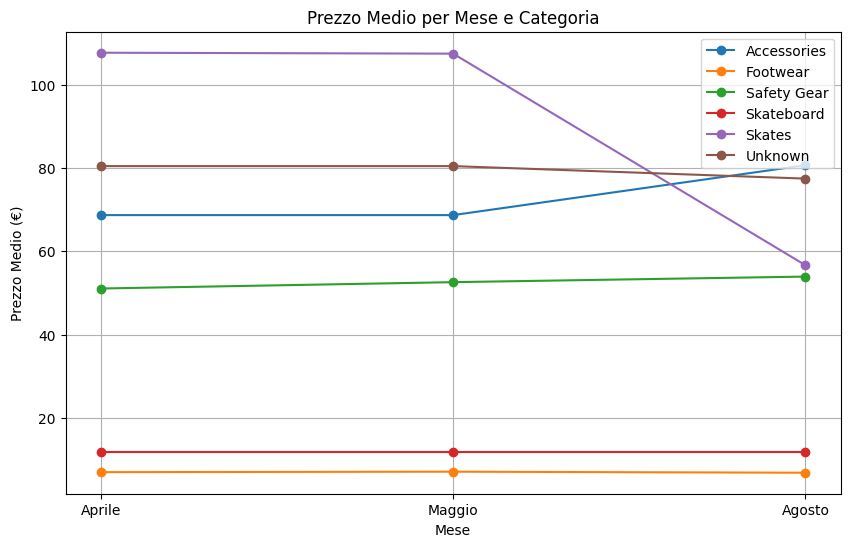

In [56]:
# Query
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {"$sort": {"_id.mese": 1, "_id.categoria": 1}}
]
risultati = list(collection.aggregate(pipeline))

# Organizza dati
mesi_map = {4: 'Aprile', 5: 'Maggio', 8: 'Agosto'}
mesi = ['Aprile', 'Maggio', 'Agosto']
categorie = sorted(set(r['_id']['categoria'] for r in risultati))
data = {cat: [None]*len(mesi) for cat in categorie}

for r in risultati:
    mese_num = r['_id']['mese']
    mese_nome = mesi_map.get(mese_num, f"Mese {mese_num}")
    if mese_nome in mesi:
        idx = mesi.index(mese_nome)
        data[r['_id']['categoria']][idx] = r['prezzo_medio']

plt.figure(figsize=(10, 6))
for cat in categorie:
    plt.plot(mesi, data[cat], marker='o', label=cat)
plt.title('Prezzo Medio per Mese e Categoria')
plt.xlabel('Mese')
plt.ylabel('Prezzo Medio (€)')
plt.legend()
plt.grid(True)
plt.show()

### Grafico: Sconto medio settimanale

In [ ]:
# Query
pipeline = [
    {
        "$group": {
            "_id": {
                "$dateToString": {
                    "format": "%Y-%m-%d",
                    "date": {"$toDate": "$scraped_at"}
                }
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id": 1}}
]
risultati = list(collection.aggregate(pipeline))

# Dati per il grafico
date = [r['_id'] for r in risultati]
sconti = [r['sconto_medio'] for r in risultati]

# Grafico
plt.figure(figsize=(10, 5))
plt.plot(date, sconti, marker='o', color='coral')
plt.title('Trend Sconto Medio Settimanale')
plt.xlabel('Data')
plt.ylabel('Sconto Medio (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Trend dello sconto medio per categoria

In [ ]:
# Query con categoria
pipeline = [
    {
        "$group": {
            "_id": {
                "data": {
                    "$dateToString": {
                        "format": "%Y-%m-%d",
                        "date": {"$toDate": "$scraped_at"}
                    }
                },
                "categoria": "$category"
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id.data": 1, "_id.categoria": 1}}
]
risultati = list(collection.aggregate(pipeline))

# Dati per il grafico
df = pd.DataFrame([
    {
        "Data": r['_id']['data'],
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": r['sconto_medio']
    }
    for r in risultati
])

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df,
    x="Data",
    y="Sconto medio (%)",
    hue="Categoria",
    marker="o"
)
plt.title("Trend Sconto Medio Settimanale per Categoria")
plt.xlabel("Data")
plt.ylabel("Sconto Medio (%)")
plt.xticks(rotation=45)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()

### Trend dello sconto medio per categoria (Aprile)

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_week_cat_sale_df4,
    x="Data",
    y="Sconto medio (%)",
    hue="Categoria",
    marker="o"
)
plt.title("Trend sconto medio settimanale per categoria (Aprile)")
plt.xlabel("Data")
plt.ylabel("Sconto medio (%)")
plt.xticks(rotation=45)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()

### Trend dello sconto medio per categoria (Maggio)

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_week_cat_sale_df5,
    x="Data",
    y="Sconto medio (%)",
    hue="Categoria",
    marker="o"
)
plt.title("Trend sconto medio settimanale per categoria (Maggio)")
plt.xlabel("Data")
plt.ylabel("Sconto medio (%)")
plt.xticks(rotation=45)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()

###  Barplot dello sconto medio totale per categoria

In [ ]:
plt.figure(figsize=(10,6))
media_per_cat = avg_week_cat_sale_df4.groupby("Categoria")["Sconto medio (%)"].mean().reset_index()
sns.barplot(
    data=media_per_cat,
    x="Categoria",
    y="Sconto medio (%)",
    palette="viridis"
)
plt.title("Sconto medio (%) per categoria (media periodo)")
plt.xlabel("Categoria")
plt.ylabel("Sconto medio (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Grafico: Top 5 prodotti per recensioni

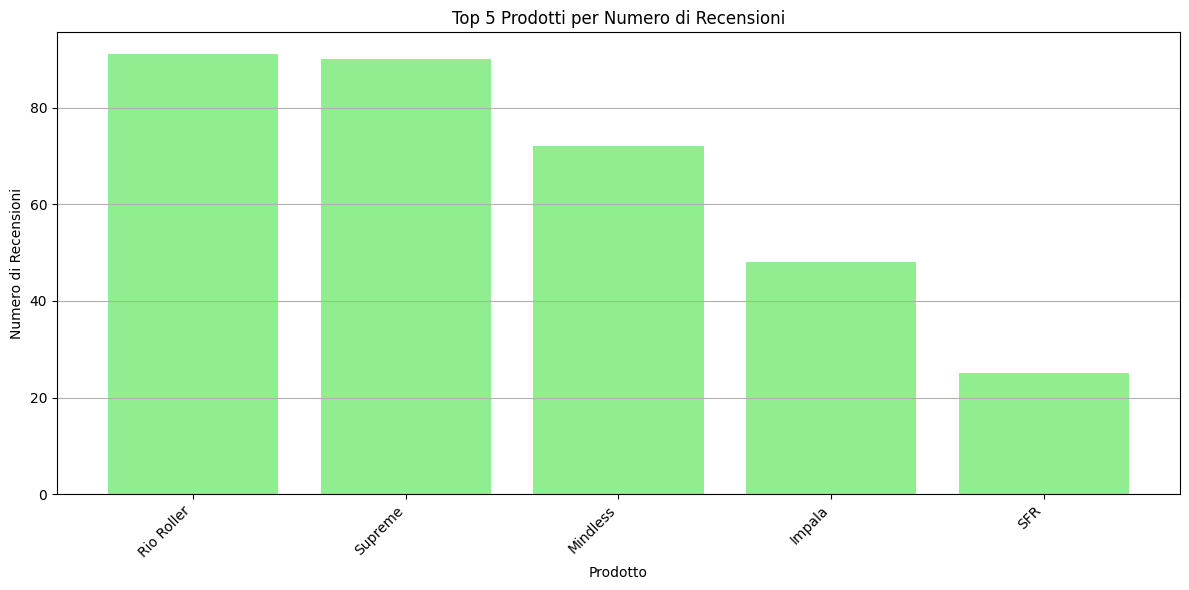

In [57]:
# Query
pipeline = [
    {"$group": {"_id": {"brand": "$brand"}, "recensioni_totali": {"$sum": "$num_reviews"}}},
    {"$sort": {"recensioni_totali": -1}},
    {"$limit": 5}
]
risultati = list(collection.aggregate(pipeline))

# Dati per il grafico
prodotti = [f"{r['_id']['brand']}" for r in risultati]
recensioni = [r['recensioni_totali'] for r in risultati]

# Grafico
plt.figure(figsize=(12, 6))
plt.bar(prodotti, recensioni, color='lightgreen')
plt.title('Top 5 Prodotti per Numero di Recensioni')
plt.xlabel('Prodotto')
plt.ylabel('Numero di Recensioni')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=kpi12_df,
    x="Intervallo sconto (%)",
    y="Recensioni medie",
    palette="Blues_d"
)
plt.title("Recensioni medie per intervallo di sconto")
plt.xlabel("Intervallo sconto (%)")
plt.ylabel("Recensioni medie")
plt.tight_layout()
plt.show()